In [2]:
%matplotlib inline

# SYDE 522 Assignment 4

## Deep Networks and Convolution

### Due: Nov 29, 2023

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and for this assignment you should use the Python package `tensorflow` to implement and train the neural network.  On most python systems this can be installed with:

```
pip install tensorflow
```

For more information on installing, see https://www.tensorflow.org/install

For this assignment, you will not need to install the GPU version of `tensorflow`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://www.tensorflow.org/install/gpu

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point.

## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [3]:
import tensorflow.keras.datasets.mnist as mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0   # rescale the images to be between 0 and 1
x_test = x_test / 255.0     # rescale the images to be between 0 and 1

Let's show the first 10 training images and their category labels.

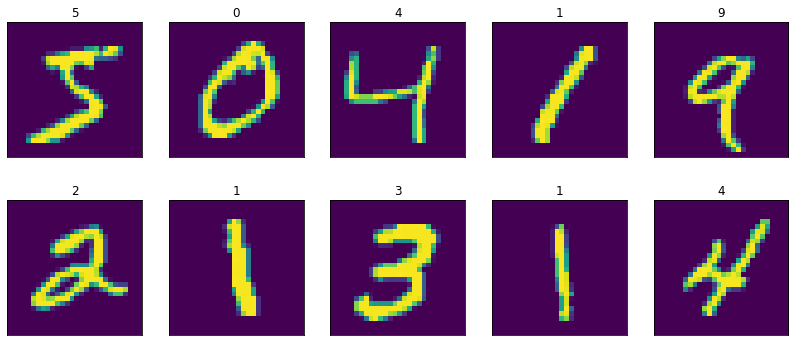

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % y_train[i])
plt.show()

The `y_train` and `y_target` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0 (one-hot encoding), so we need to convert to that format.  (Note: there is a special loss function `sparse_categorical_crossentropy` that automatically converts for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [6]:
import numpy as np

y_train_target = np.eye(10)[y_train]
y_test_target = np.eye(10)[y_test]
print('original target:', y_train[0])
print('  vector target:', y_train_target[0])

original target: 5
  vector target: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Dense` is a layer where all the components are connected to all of the previous layer's outputs.

In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
])

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
              loss=my_loss,
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

Before doing any training, let's see how well it performs.

In [8]:
loss, accuracy = model.evaluate(x_test,  y_test_target)

313/313 [==============================] - 2s 968us/step - loss: 0.1809 - accuracy: 0.1000


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

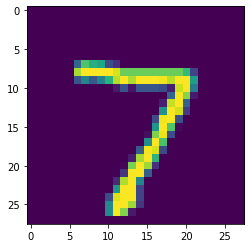

actual output from network: [0.         0.25260103 0.02468198 0.3353357  0.         0.24589221
 0.5398121  0.         0.05717806 0.        ]
category (the largest output): 6


In [9]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])


So it currently thinks the first image in the test dataset is is a 6, when it should actually be a 7 (note: when you run this, you may get a different number, as each network starts out randomly different).  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data, since we're looking at it while we are doing training.  Real testing data would only ever be used at the very end after all training has finished).

In [10]:
model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0363 - accuracy: 0.7699 - val_loss: 0.0258 - val_accuracy: 0.8472
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0217 - accuracy: 0.8895 - val_loss: 0.0181 - val_accuracy: 0.9133
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0170 - accuracy: 0.9233 - val_loss: 0.0159 - val_accuracy: 0.9273
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0154 - accuracy: 0.9316 - val_loss: 0.0147 - val_accuracy: 0.9338
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0142 - accuracy: 0.9378 - val_loss: 0.0138 - val_accuracy: 0.9374


We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

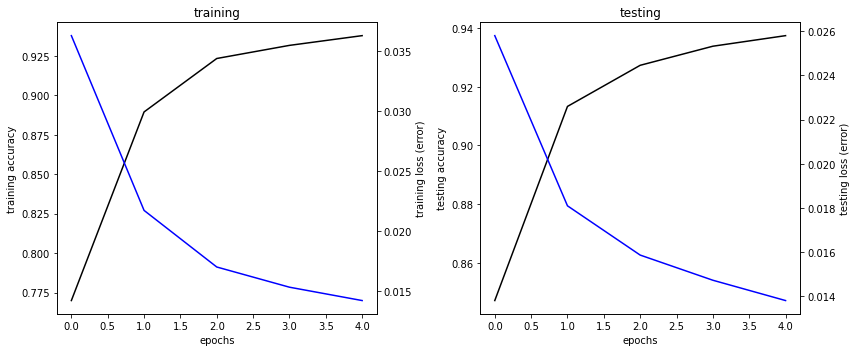

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

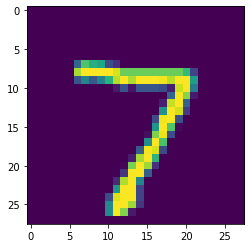

actual output from network: [0.        0.        0.        0.        0.        0.        0.
 0.8656349 0.        0.       ]
category (the largest output): 7


In [12]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [13]:
confusion=np.zeros((10,10), dtype=int)
np.add.at(confusion, (category, y_test), 1)
print(confusion)

[[ 962    0    8    4    2    8    9    7    7   14]
 [   1 1118    1    0    5    0    3   12    6    6]
 [   2    4  954   24    4    5    6   22    4    0]
 [   1    4    7  928    0   24    2    3   12   16]
 [   2    0   10    2  916    7    7    7    7   40]
 [   2    1    2   17    0  798    8    0   11    6]
 [   4    3    8    1   11   17  918    1    7    0]
 [   2    1   13   10    3    3    2  958    6    9]
 [   4    4   24   22   10   25    3    2  912    8]
 [   0    0    5    2   31    5    0   16    2  910]]


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix (yours will be different), 9's got mis-calssified as 4's a lot (and vice-versa).

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `model.fit` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. You should see that each time you train the model, it behaves differently.  Why does this happen? 

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs for 10 different runs on one plot.  On a separate plot show the testing error vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called Adam that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=tf.keras.optimizers.SGD(learning_rate=0.1)` to `optimizer="adam"`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = np.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))   # note that we now use y_train, not y_train_target

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  We do not need the testing accuracy over the epochs, so you can switch back to setting `epochs=10` rather than using the `for` loop.  Plot the average training accuracy vs different numbers of neurons.  On a separate plot, plot the average testing accuracy vs different numbers of neurons.  What trend do you observe?

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0
y_test = y_test[:,0]

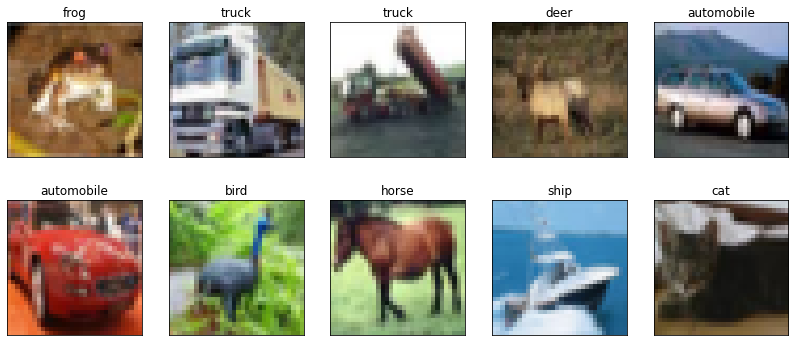

In [16]:
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(y_train[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(32, 32, 3)`, as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy.  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),    
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

Train this network for 10 epochs, and do this 10 times and plot the training and testing accuracy.  How well does the model perform?  

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).